In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits import mplot3d
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates
from kneed import KneeLocator

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#PCA
from sklearn.decomposition import PCA
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df=pd.read_csv("ravdess_features.csv")

In [4]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])

In [5]:
df["vocal_channel_fill"]=df["vocal_channel"]
df["vocal_channel_fill"]=df["vocal_channel_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["intensity_fill"]=df["intensity"]
df["intensity_fill"]=df["intensity_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [6]:
df.corr().loc[["length_ms", "vocal_channel_fill", "frame_count_fill", "intensity_fill", "zero_crossings_sum", "sex", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"], ["length_ms", "vocal_channel_fill", "frame_count_fill", "intensity_fill", "zero_crossings_sum", "sex", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"]].style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

## Statistiche generali

<AxesSubplot:xlabel='stft_min', ylabel='Density'>

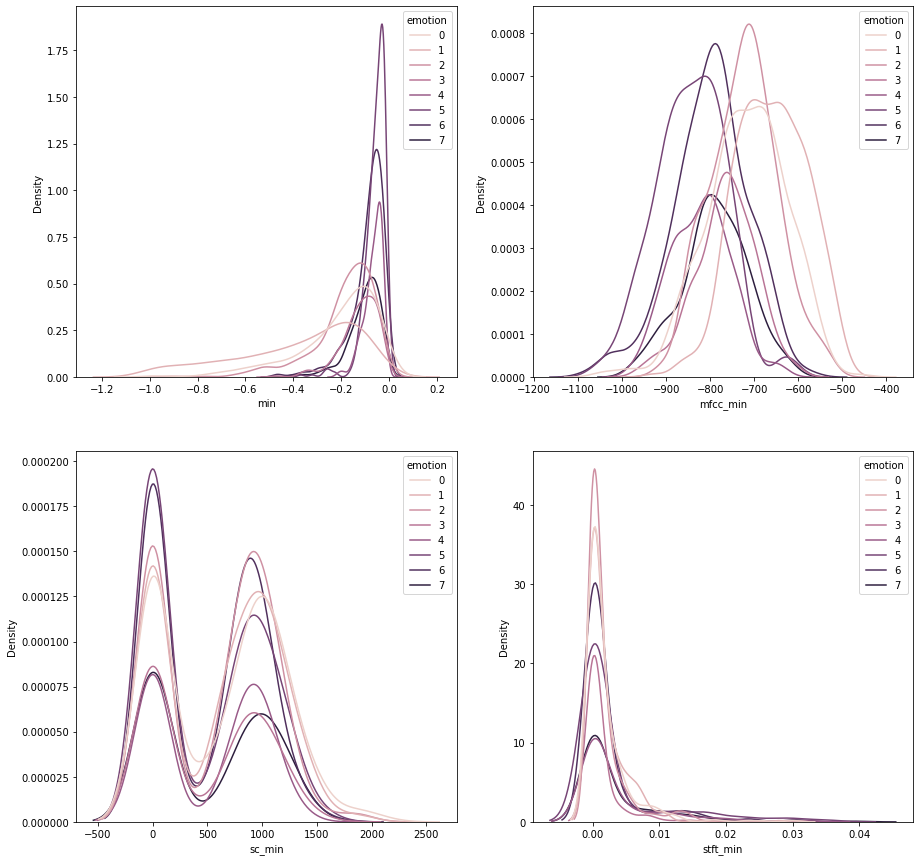

In [7]:
#min df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_min", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='intensity_fill', ylabel='Density'>

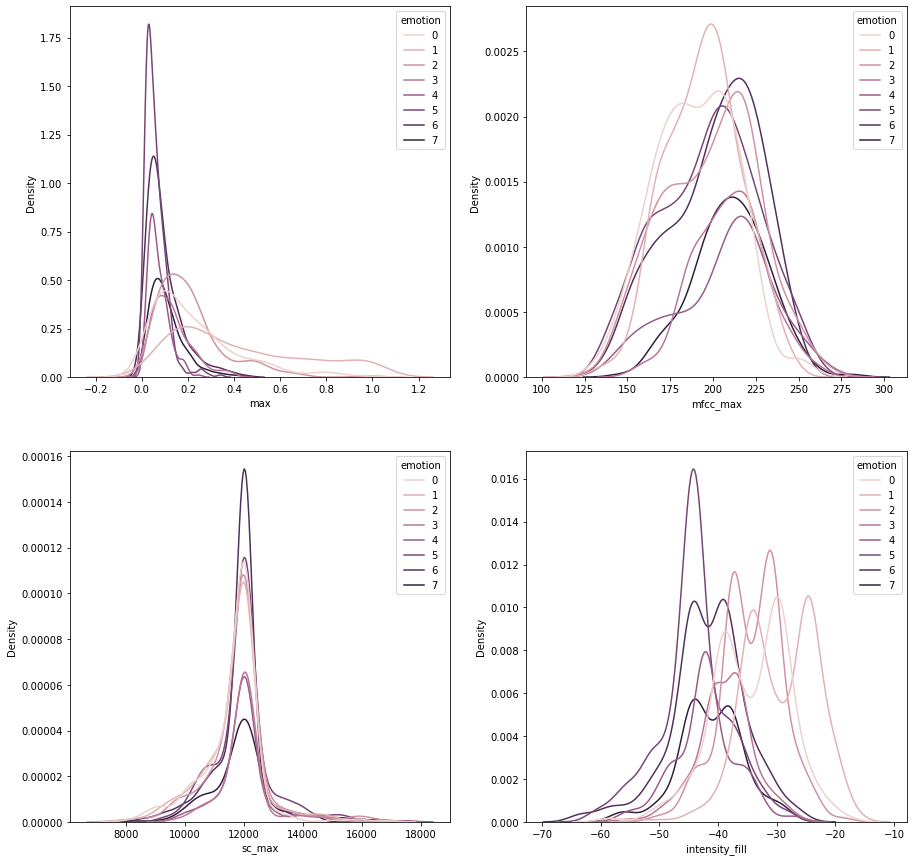

In [8]:
#max df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="max", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_max", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_max", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="intensity_fill", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_mean', ylabel='Density'>

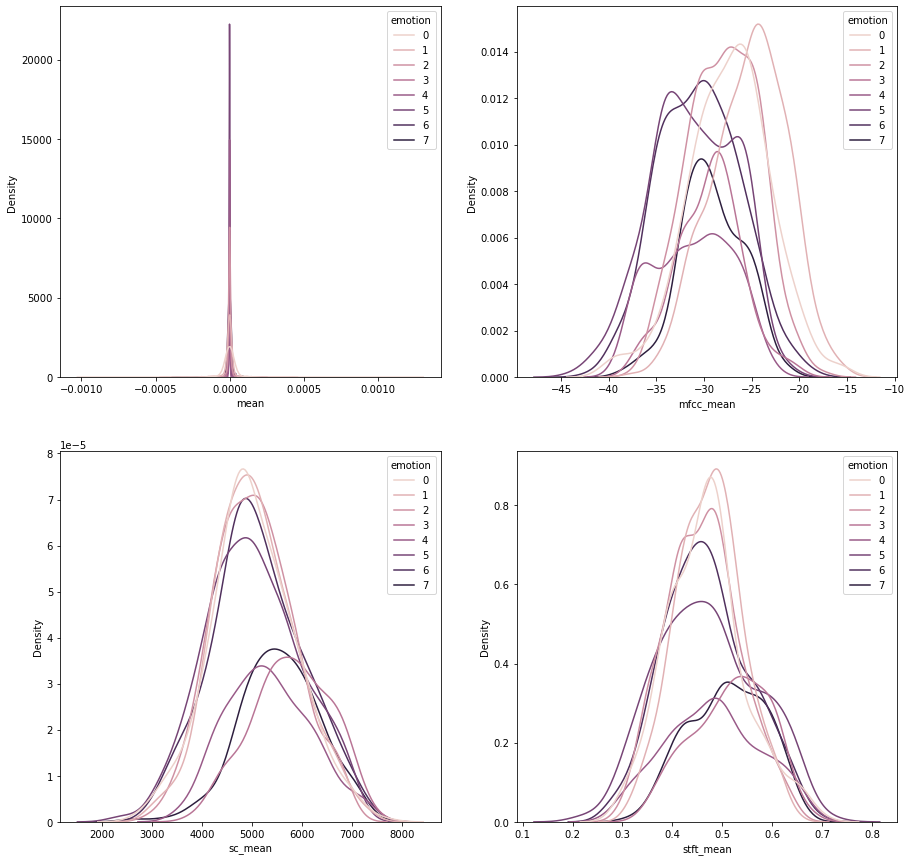

In [9]:
#mean df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_mean", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_std', ylabel='Density'>

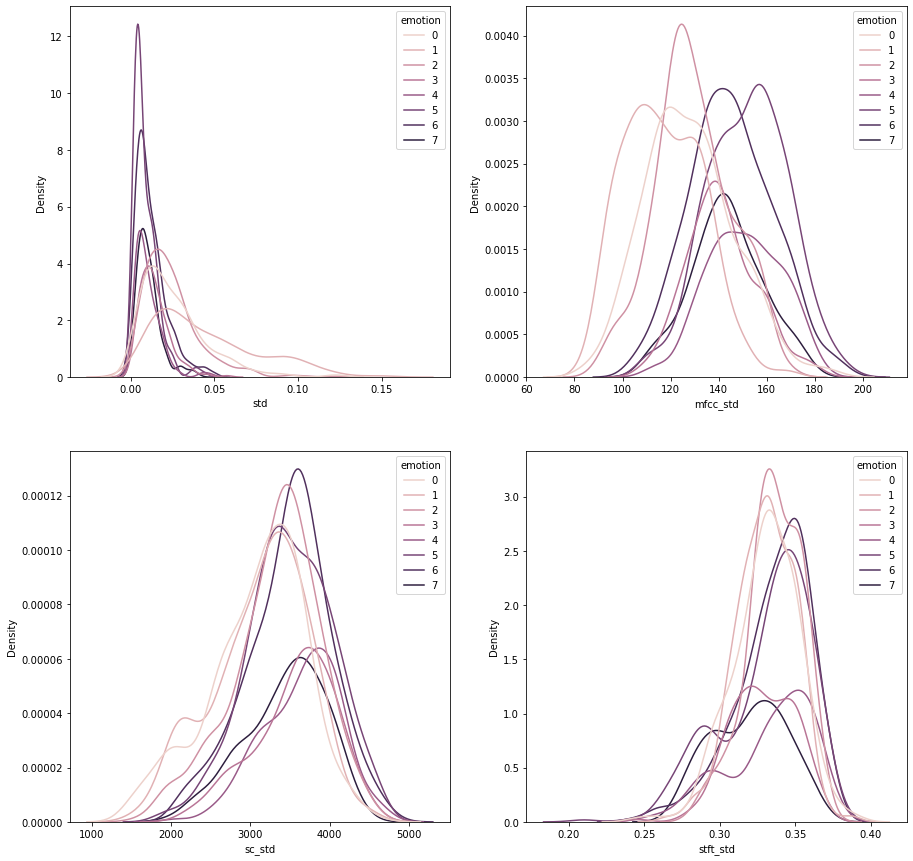

In [10]:
#std
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_std", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_skew', ylabel='Density'>

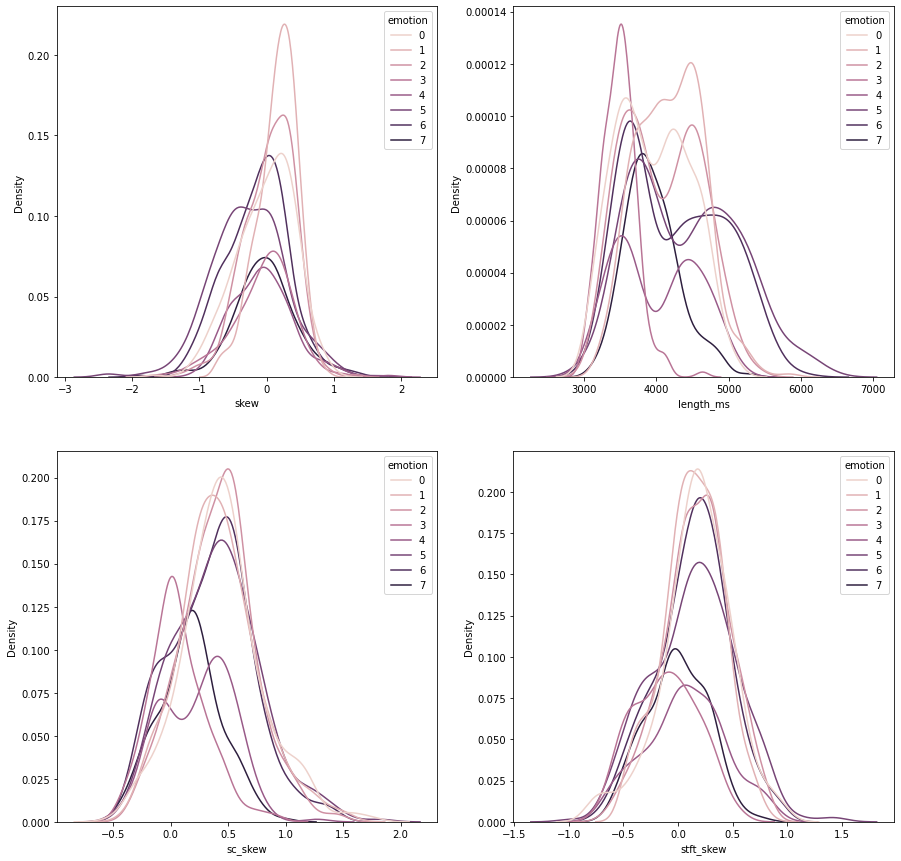

In [11]:
#skew and length
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_skew", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_kur', ylabel='Density'>

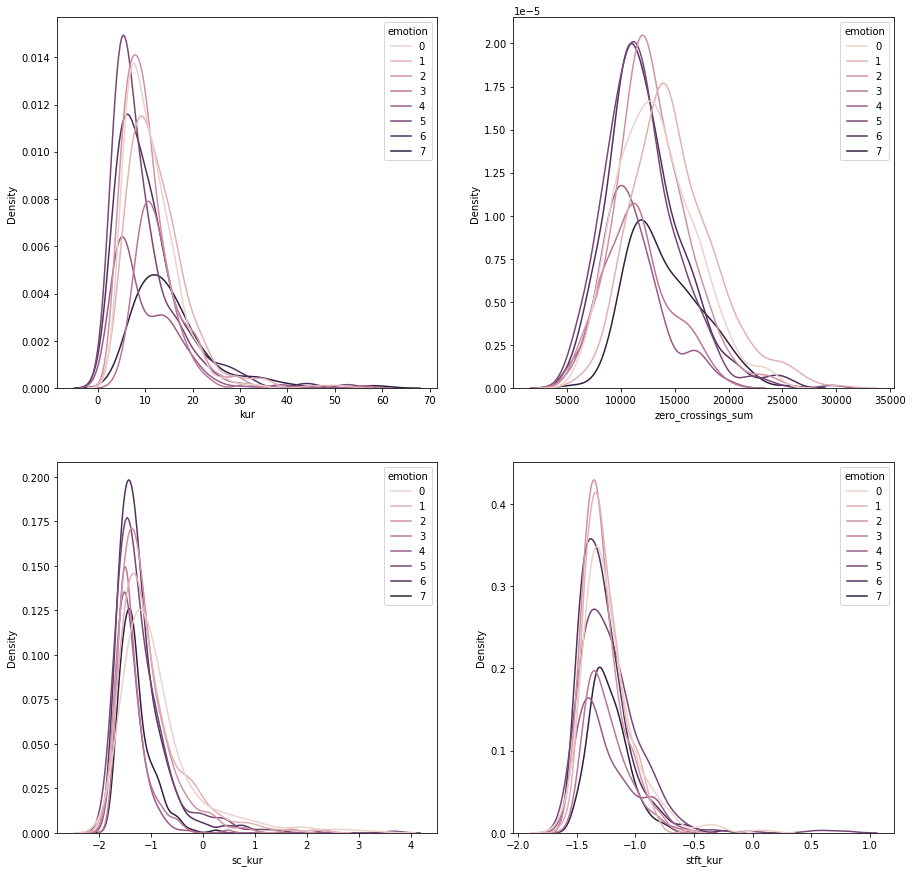

In [12]:
#zero-crossing-sum and kurtosis
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_kur", hue="emotion", ax=axs[1][1])

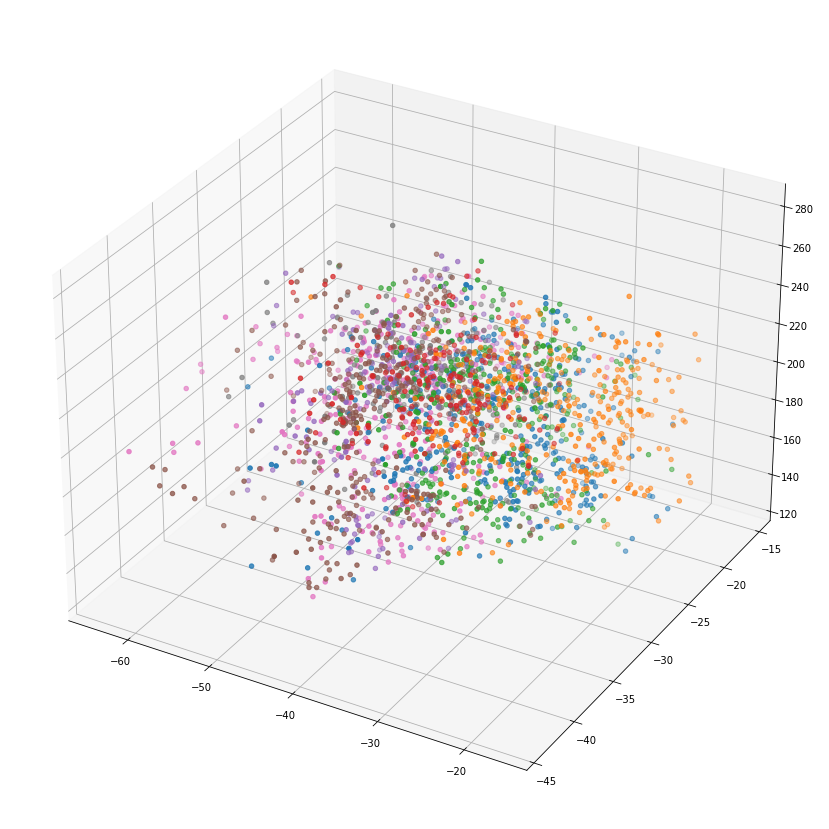

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.emotion.unique():
    ax.scatter(df.intensity_fill[df.emotion==s],df.mfcc_mean[df.emotion==s],df.mfcc_max[df.emotion==s],label=s)

## Outliers

In [14]:
#più interessanti
"""fig, axs = plt.subplots(5,2,figsize=(15,15))
sns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])
sns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])
sns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])
sns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])"""

'fig, axs = plt.subplots(5,2,figsize=(15,15))\nsns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])\nsns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])\nsns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])\nsns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])\nsns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])\nsns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])\nsns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])\nsns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])\nsns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])\nsns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])'

# Clustering

In [15]:
#elimino le variabili non numeriche, missing values, entrate costanti, correlate più di |0.9|
dfcopy1=df.copy()
df = df.drop(["emotion", "intensity_fill", "mfcc_min", "stft_mean", "min", "max", "sample_width", "frame_rate", "stft_max", "modality", "intensity", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max", "vocal_channel_fill", "frame_count"], axis=1)

In [16]:
df.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [17]:
df2 = df.drop(columns=["length_ms", "std", "sc_skew", "mfcc_mean", "sc_mean", "sc_std"])

In [18]:
df2.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

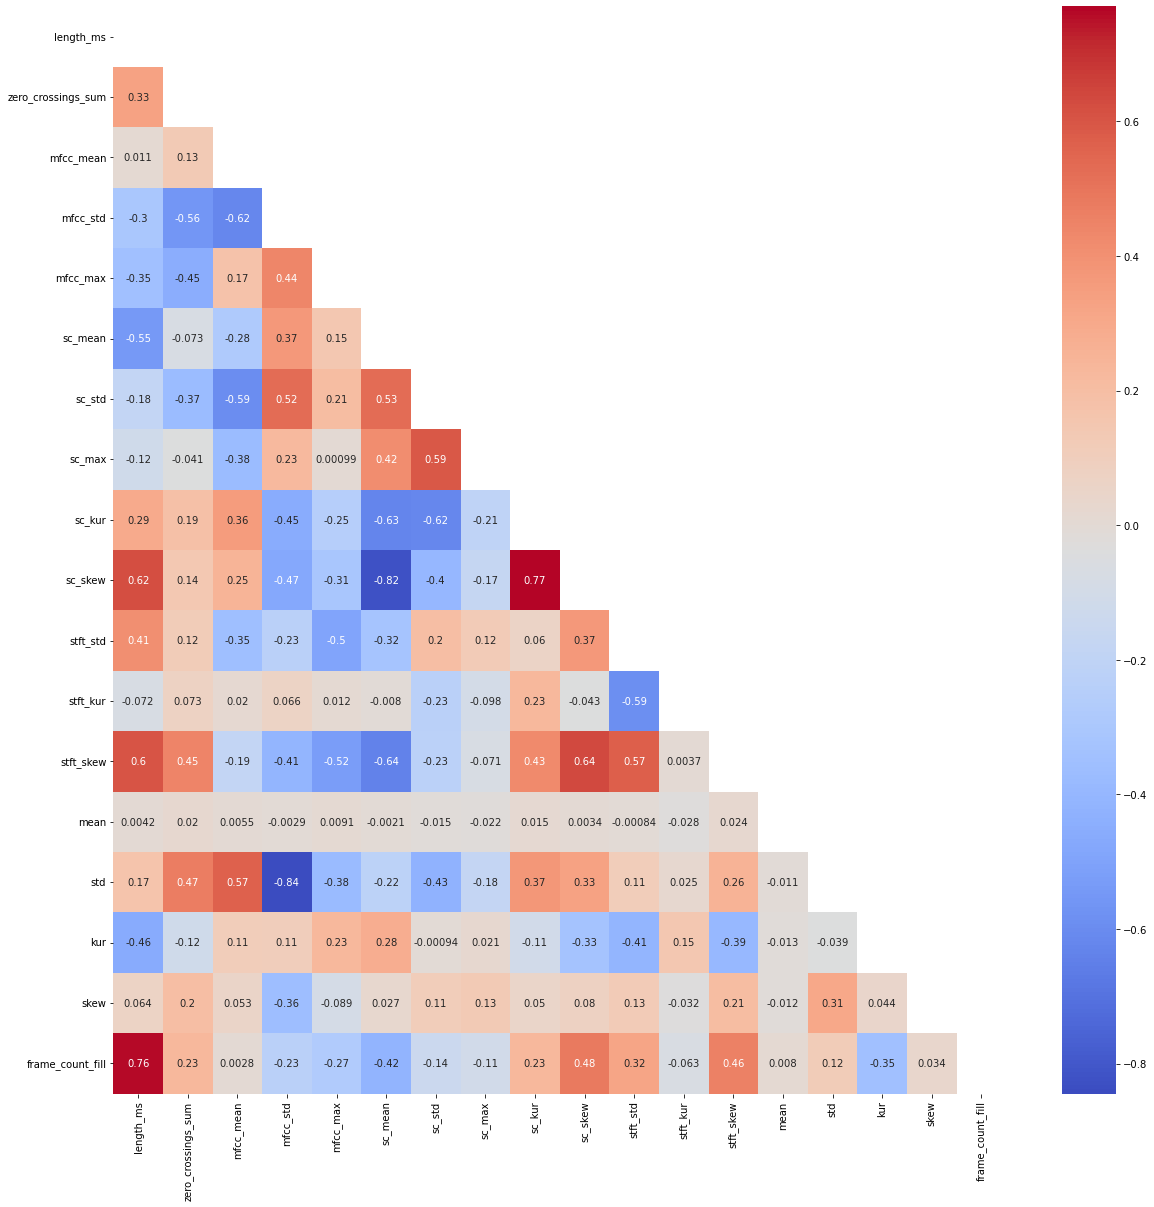

In [19]:
fig=plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(df.corr()))
dataplot = sns.heatmap(df.corr(), cmap="coolwarm", annot=True, mask=mask)
plt.show()

In [20]:
X = df.values
X1 = df2.values
#X2 = dfcopy3.values
#X3 = dfcopy4.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
X_minmax1 = scaler.fit_transform(X1)
#X_minmax2 = scaler.fit_transform(X2)
#X_minmax3 = scaler.fit_transform(X3)

<AxesSubplot:ylabel='Count'>

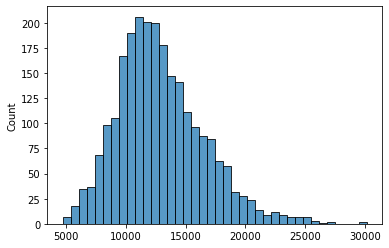

In [21]:
sns.histplot(data=X, x=X[:,1])

<AxesSubplot:ylabel='Count'>

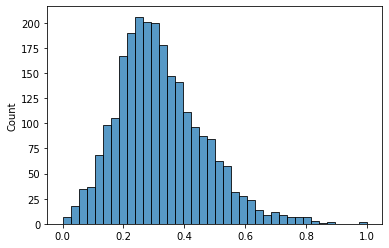

In [22]:
sns.histplot(data=X_minmax, x=X_minmax[:,1])

## Kmeans

In [23]:
sse_list = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

In [24]:
sse_list1 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax1)
    sse_list1.append(kmeans.inertia_)

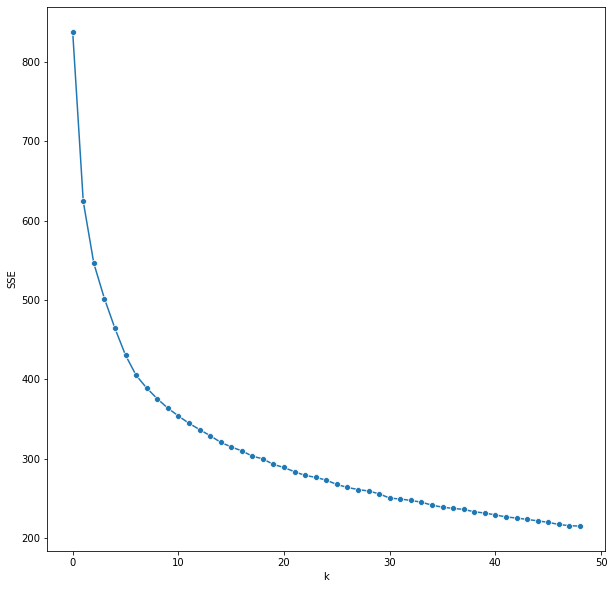

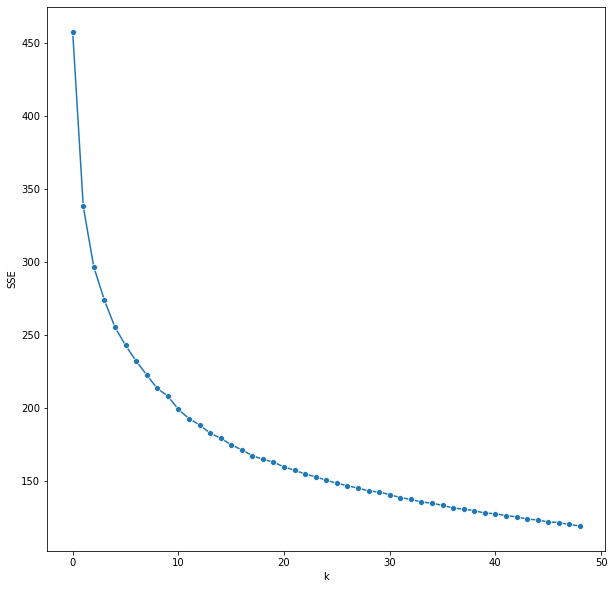

In [25]:
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list1)), y=sse_list1, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [26]:
#knee locator
kn = KneeLocator(range(len(sse_list)), sse_list, curve='convex', direction='decreasing')
print(kn.knee)

kn1 = KneeLocator(range(len(sse_list1)), sse_list1, curve='convex', direction='decreasing')
print(kn1.knee)

8
10


In [27]:
kmeans = KMeans(init='k-means++', n_clusters=kn.knee, n_init=10, max_iter=100)
kmeans.fit(X_minmax)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_minmax, kmeans.labels_))

kmeans1 = KMeans(init='k-means++', n_clusters=kn1.knee, n_init=10, max_iter=100)
kmeans1.fit(X_minmax1)
hist, bins = np.histogram(kmeans1.labels_, bins=range(0, len(set(kmeans1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans1.inertia_)
print('silhouette', silhouette_score(X_minmax1, kmeans1.labels_))

labels {0: 279, 1: 284, 2: 364, 3: 189, 4: 378, 5: 345, 6: 296, 7: 317}
sse 389.36743456360455
silhouette 0.1546994324001652
labels {0: 234, 1: 316, 2: 138, 3: 274, 4: 405, 5: 196, 6: 31, 7: 344, 8: 300, 9: 214}
sse 205.14215417954168
silhouette 0.13845545038192142


In [28]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean    mfcc_std   mfcc_max  \
0       3737               16995 -33.485947  134.654860  171.69092   
1       3904               13906 -29.502108  130.485630  205.00770   
2       4671               18723 -30.532463  126.577110  165.45653   
3       3637               11617 -36.059555  159.725160  190.03609   
4       4404               15137 -31.405996  122.125824  161.13400   

       sc_mean       sc_std        sc_max    sc_kur   sc_skew  stft_std  \
0  5792.550744  3328.055457  13541.959028 -1.120769  0.250940  0.335533   
1  5197.620555  4040.931570  12000.290443 -1.531204  0.219582  0.352380   
2  4830.743037  3332.131300  12007.751173 -1.130153  0.436699  0.352270   
3  5376.446478  4053.663073  12048.223893 -1.497765  0.098802  0.360552   
4  5146.012474  3442.724109  12025.582707 -1.167544  0.496066  0.350655   

   stft_kur  stft_skew          mean       std        kur      skew  \
0 -1.215025   0.403514  3.844916e-07  0.014482   9.406061  0.273153   
1 -1.384174   0.290905 -7.149491e-08  0.020417  19.564187  0.292157   
2 -1.242947   0.470350  2.429985e-06  0.024317   4.881241  0.302659   
3 -1.445318   0.274756  2.373929e-07  0.003561  13.040259 -0.081014   
4 -1.366742   0.318926  8.454691e-07  0.027522   7.485109  0.414872   

   frame_count_fill  
0          179379.0  
1          187387.0  
2          224224.0  
3          174575.0  
4          211411.0

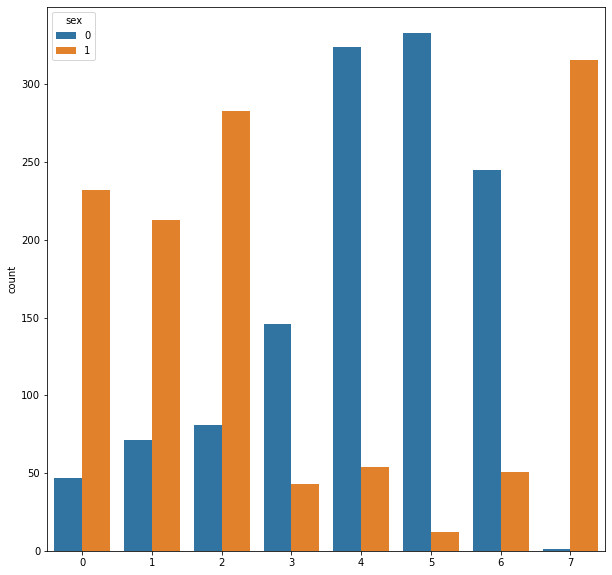

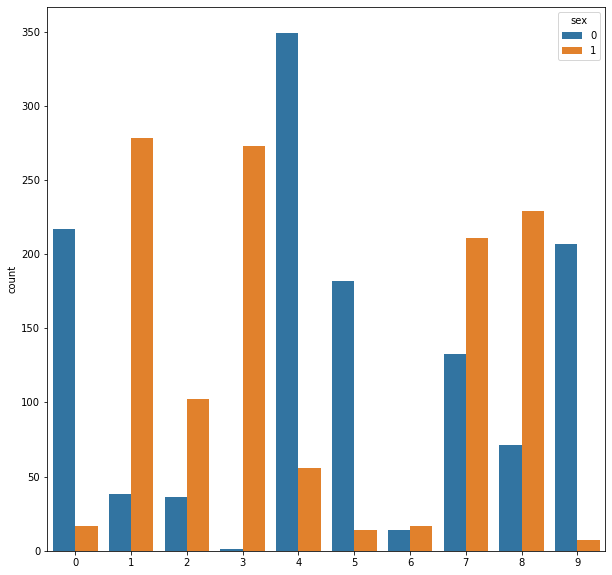

In [29]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=kmeans.labels_, hue="sex")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=kmeans1.labels_, hue="sex")
plt.show()

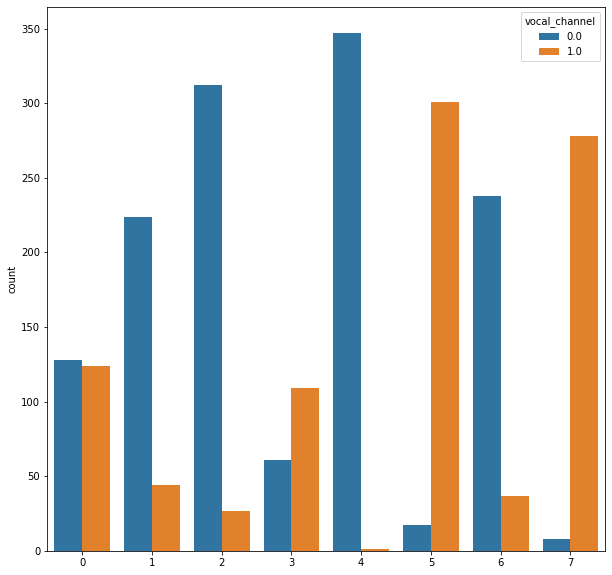

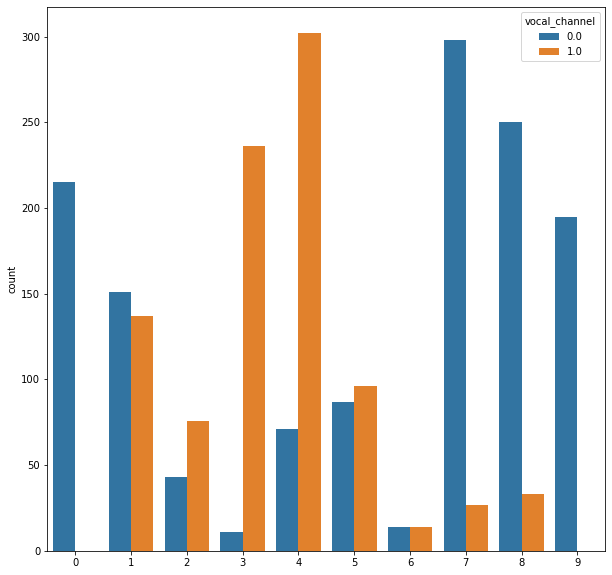

In [30]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=kmeans.labels_, hue="vocal_channel")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=kmeans1.labels_, hue="vocal_channel")
plt.show()

<AxesSubplot:xlabel='mfcc_max', ylabel='mfcc_mean'>

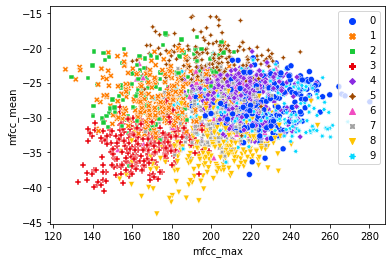

In [31]:
sns.scatterplot(data=df, x="mfcc_max", y="mfcc_mean", hue=kmeans1.labels_, style=kmeans1.labels_,
                palette="bright")

In [32]:
len(kmeans.cluster_centers_)

8

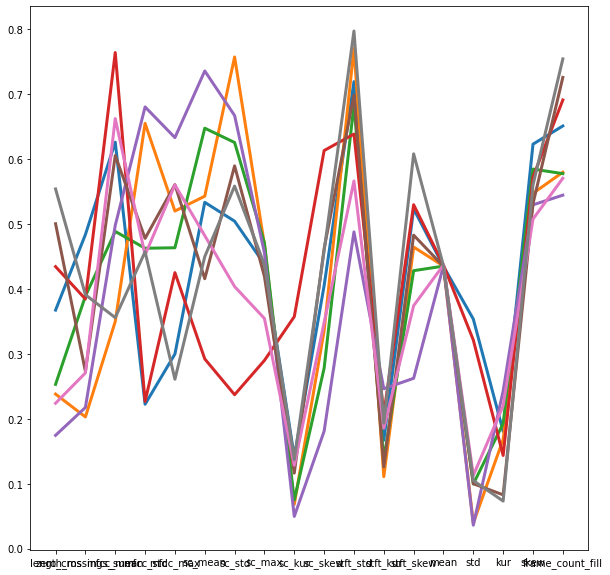

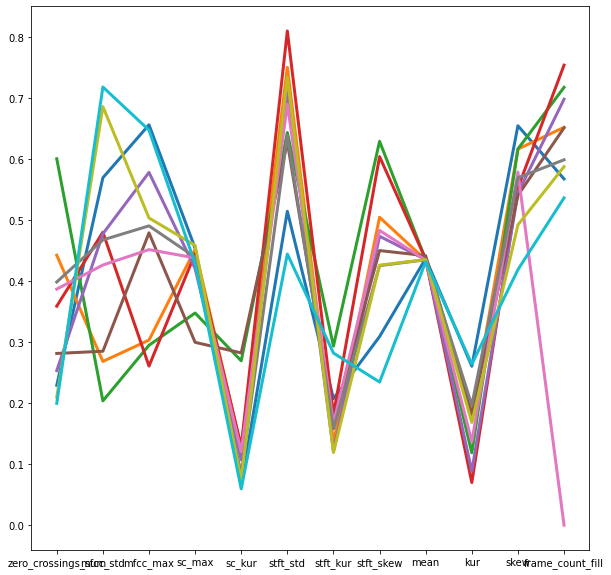

"\nplt.figure(figsize=(10,10))\nfor i in range(len(kmeans2.cluster_centers_)):\n    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)\nplt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))\nplt.show()\n\nplt.figure(figsize=(10,10))\nfor i in range(len(kmeans3.cluster_centers_)):\n    plt.plot(range(0, len(kmeans3.cluster_centers_[0])), kmeans3.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)\nplt.xticks(range(len(dfcopy4.columns)), list(dfcopy4))\nplt.show()"

In [33]:
plt.figure(figsize=(10,10))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, len(kmeans.cluster_centers_[0])), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(df.columns)), list(df))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans1.cluster_centers_)):
    plt.plot(range(0, len(kmeans1.cluster_centers_[0])), kmeans1.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(df2.columns)), list(df2))
plt.show()
'''
plt.figure(figsize=(10,10))
for i in range(len(kmeans2.cluster_centers_)):
    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans3.cluster_centers_)):
    plt.plot(range(0, len(kmeans3.cluster_centers_[0])), kmeans3.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy4.columns)), list(dfcopy4))
plt.show()'''

### kmeans PCA analysis

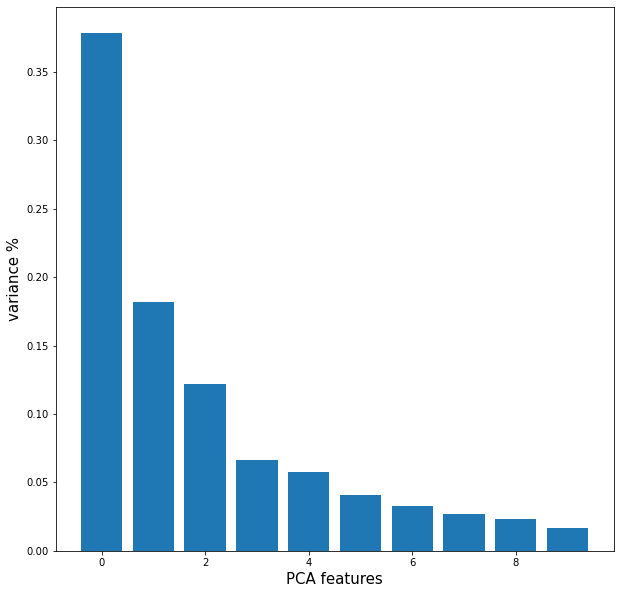

In [34]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_minmax)

features = range(pca.n_components_)

plt.figure(figsize=(10,10))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features', fontsize=15)
plt.ylabel('variance %', fontsize=15)
plt.show()

([<matplotlib.axis.XTick at 0x7fb9ff20ee50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

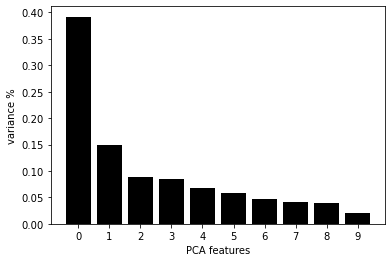

In [35]:
pca = PCA(n_components=10)
principal_components1 = pca.fit_transform(X_minmax1)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

2D PCA

In [36]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_minmax)
principal2dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2"])

principal_components1 = pca.fit_transform(X_minmax1)
principal2dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2"])

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

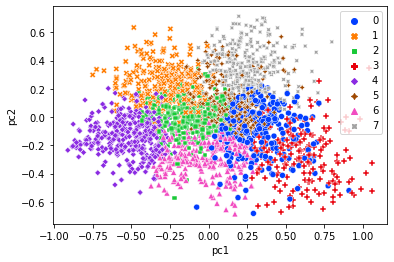

In [37]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=kmeans.labels_, style=kmeans.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

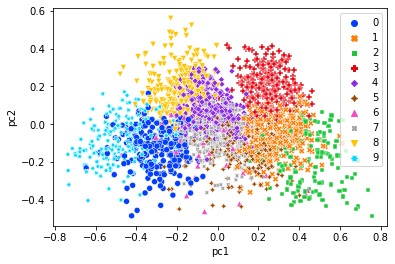

In [38]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=kmeans1.labels_, style=kmeans1.labels_, palette="bright")

3D PCA

In [39]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_minmax)
principal3dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])

principal_components1 = pca.fit_transform(X_minmax1)
principal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])

In [40]:
principal3dDf["klabel"]=kmeans.labels_
principal3dDf1["klabel"]=kmeans1.labels_

<Figure size 720x720 with 0 Axes>

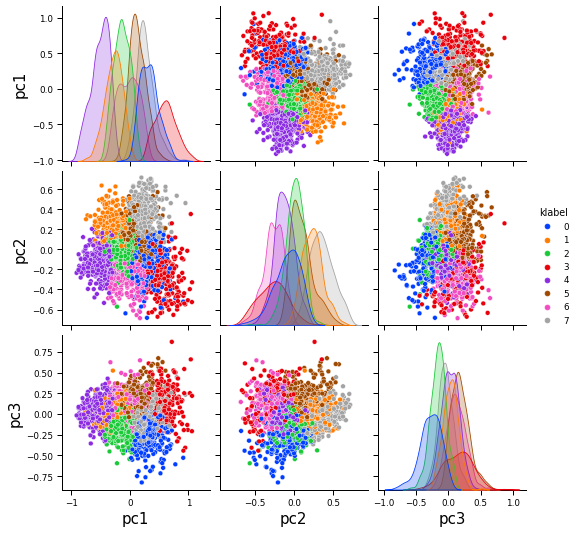

In [41]:
sns.set_context("paper", rc={"axes.labelsize":15, "legend":10})
plt.figure(figsize=(10,10))
sns.pairplot(data=principal3dDf, hue="klabel", palette="bright")
plt.show()

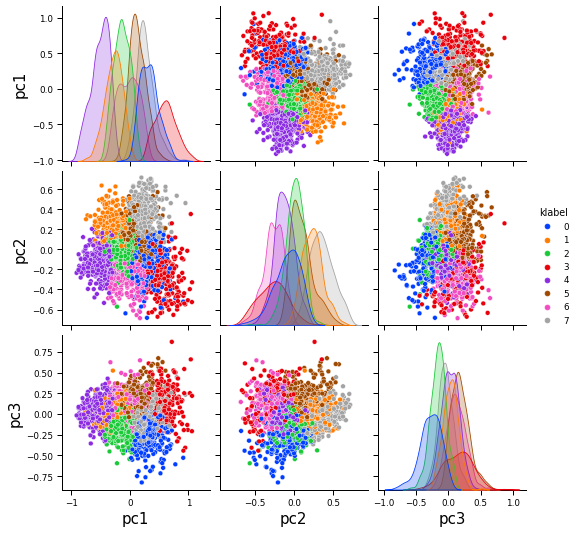

In [42]:
sns.pairplot(data=principal3dDf, hue="klabel", palette="bright")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

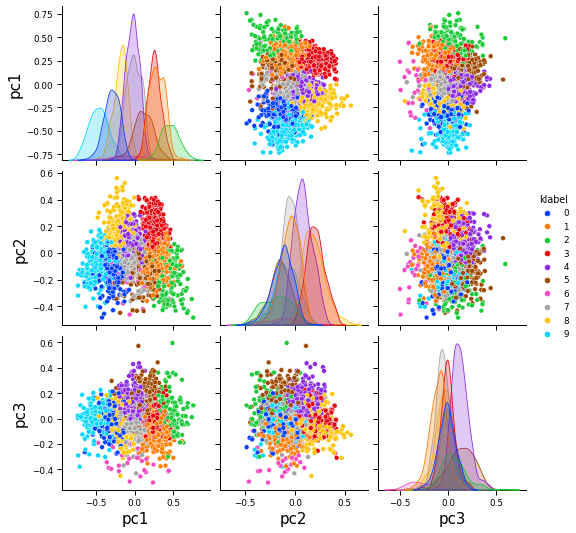

In [43]:
sns.pairplot(data=principal3dDf1, hue="klabel", palette="bright")
plt.show

## DBScan

In [44]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean    mfcc_std   mfcc_max  \
0       3737               16995 -33.485947  134.654860  171.69092   
1       3904               13906 -29.502108  130.485630  205.00770   
2       4671               18723 -30.532463  126.577110  165.45653   
3       3637               11617 -36.059555  159.725160  190.03609   
4       4404               15137 -31.405996  122.125824  161.13400   

       sc_mean       sc_std        sc_max    sc_kur   sc_skew  stft_std  \
0  5792.550744  3328.055457  13541.959028 -1.120769  0.250940  0.335533   
1  5197.620555  4040.931570  12000.290443 -1.531204  0.219582  0.352380   
2  4830.743037  3332.131300  12007.751173 -1.130153  0.436699  0.352270   
3  5376.446478  4053.663073  12048.223893 -1.497765  0.098802  0.360552   
4  5146.012474  3442.724109  12025.582707 -1.167544  0.496066  0.350655   

   stft_kur  stft_skew          mean       std        kur      skew  \
0 -1.215025   0.403514  3.844916e-07  0.014482   9.406061  0.273153   
1 -1.384174   0.290905 -7.149491e-08  0.020417  19.564187  0.292157   
2 -1.242947   0.470350  2.429985e-06  0.024317   4.881241  0.302659   
3 -1.445318   0.274756  2.373929e-07  0.003561  13.040259 -0.081014   
4 -1.366742   0.318926  8.454691e-07  0.027522   7.485109  0.414872   

   frame_count_fill  
0          179379.0  
1          187387.0  
2          224224.0  
3          174575.0  
4          211411.0

In [45]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

dist1 = pdist(X_minmax1, 'euclidean')
dist1 = squareform(dist1)

In [99]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

kth_distances1 = []
for d in dist1:
    index_kth_distance = np.argsort(d)[k] 
    kth_distances1.append(d[index_kth_distance])  

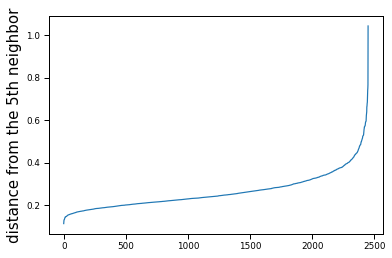

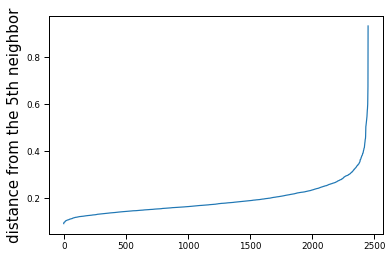

In [100]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances1)), sorted(kth_distances1))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

In [101]:
#knee locator
kn = KneeLocator(range(len(kth_distances)), sorted(kth_distances), curve='convex', direction='increasing')
optimal_eps=np.interp(kn.knee, range(len(kth_distances)), sorted(kth_distances))
optimal_eps

0.4984226280905469

In [102]:
kn = KneeLocator(range(len(kth_distances1)), sorted(kth_distances1), curve='convex', direction='increasing')
optimal_eps1=np.interp(kn.knee, range(len(kth_distances1)), sorted(kth_distances1))
optimal_eps1

0.3455921282042676

In [103]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(X_minmax)
hist, bins = np.histogram(dbscan.labels_, bins=range(0, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, dbscan.labels_))

dbscan1 = DBSCAN(eps=optimal_eps1, min_samples=5)
dbscan1.fit(X_minmax1)
hist, bins = np.histogram(dbscan1.labels_, bins=range(0, len(set(dbscan1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax1, dbscan1.labels_))

labels {0: 2408, 1: 22, 2: 0}
silhouette 0.1998691726847618
labels {0: 2397, 1: 24, 2: 0}
silhouette 0.3108027484916817


In [104]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([  22, 2408,   22]))

In [105]:
np.unique(dbscan1.labels_, return_counts=True)

(array([-1,  0,  1]), array([  31, 2397,   24]))

In [51]:
principal3dDf = principal3dDf.drop(columns=["klabel"])
principal3dDf1 = principal3dDf1.drop(columns=["klabel"])
principal3dDf["dbscan_labels"]=dbscan.labels_
principal3dDf1["dbscan_labels"]=dbscan1.labels_

### DBscan PCA analysis

2D

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

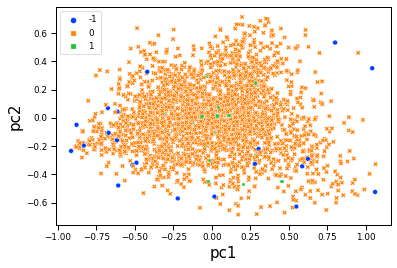

In [53]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=dbscan.labels_, style=dbscan.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

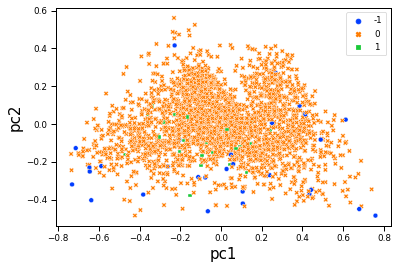

In [54]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=dbscan1.labels_, style=dbscan1.labels_, palette="bright")

3D

<Figure size 720x720 with 0 Axes>

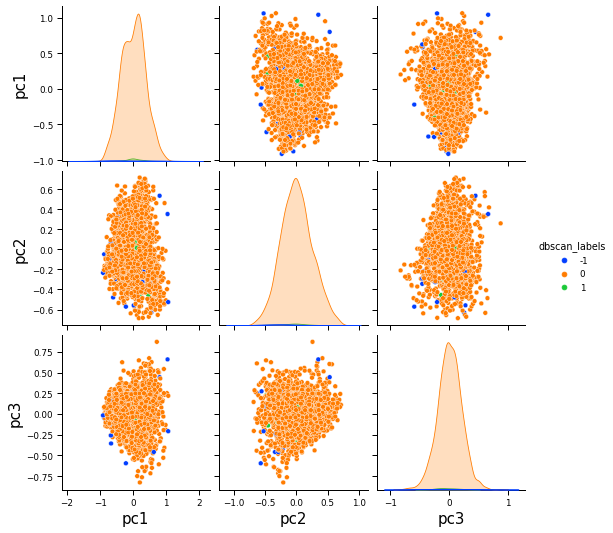

In [55]:
sns.set_context("paper", rc={"axes.labelsize":15, "legend":10})
plt.figure(figsize=(10,10))
sns.pairplot(data=principal3dDf, hue="dbscan_labels", palette="bright")
plt.show()

<Figure size 720x720 with 0 Axes>

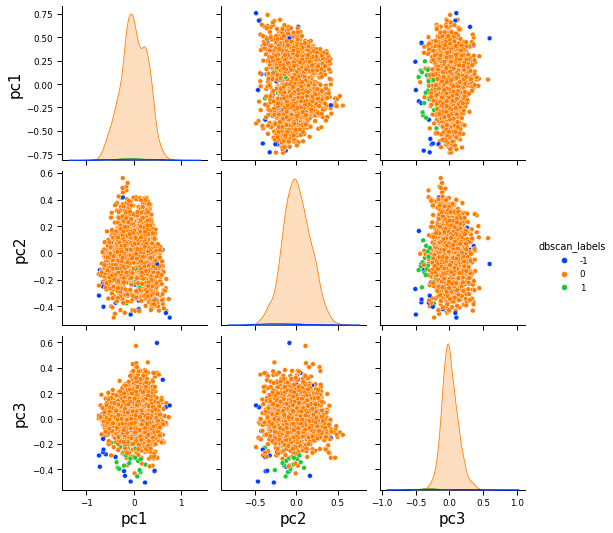

In [56]:
sns.set_context("paper", rc={"axes.labelsize":15, "legend":10})
plt.figure(figsize=(10,10))
sns.pairplot(data=principal3dDf1, hue="dbscan_labels", palette="bright")
plt.show()

## Hierarchical clustering

In [57]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Ward linkage

In [58]:
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)

model1_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)

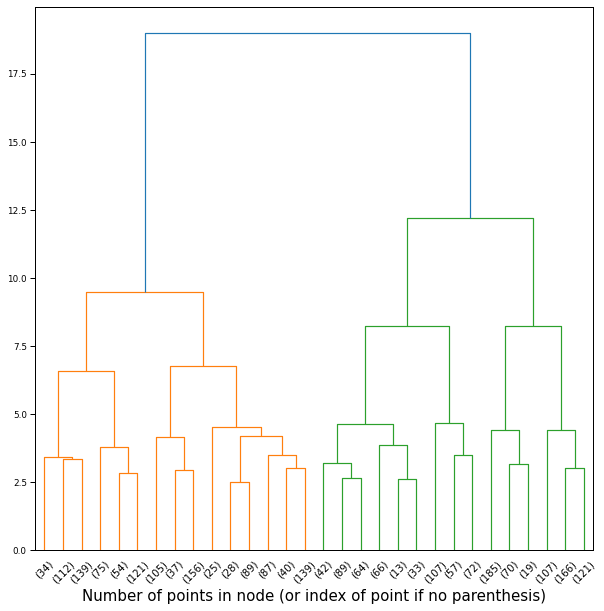

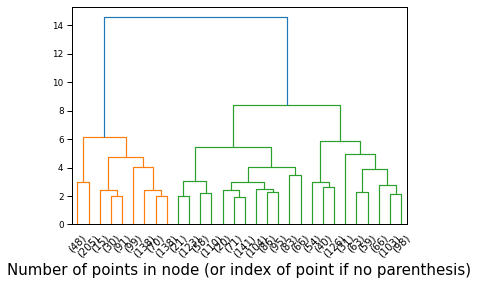

In [59]:
plt.figure(figsize=(10,10))
plot_dendrogram(model_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis)", fontsize=15)
plt.show()

plot_dendrogram(model1_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [60]:
model_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)
count0 = 0
count1 = 0
count2 = 0
for i in range(len(model_ward.labels_)):
    if (model_ward.labels_[i] == 0):
        count0 = count0 + 1
    elif (model_ward.labels_[i] == 1):
        count1 = count1 + 1
    else:
        count2 = count2 + 1
print("number of points in the clusters: ", count0, count1)

number of points in the clusters:  1211 1241


In [61]:
model1_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)
count0 = 0
count1 = 0
count2 = 0
for i in range(len(model_ward.labels_)):
    if (model1_ward.labels_[i] == 0):
        count0 = count0 + 1
    elif (model1_ward.labels_[i] == 1):
        count1 = count1 + 1
    else:
        count2 = count2 + 1
print("number of points in the clusters: ", count0, count1)

number of points in the clusters:  1618 834


In [107]:
model_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)
hist, bins = np.histogram(dbscan.labels_, bins=range(0, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, dbscan.labels_))

model1_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)
hist, bins = np.histogram(model1_ward.labels_, bins=range(0, len(set(model1_ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax1, model1_ward.labels_))

labels {0: 2408, 1: 22, 2: 0}
silhouette 0.1998691726847618
labels {0: 1618, 1: 834}
silhouette 0.21506878251624473


In [111]:
np.unique(model1_ward.labels_, return_counts=True)

(array([0, 1]), array([1618,  834]))

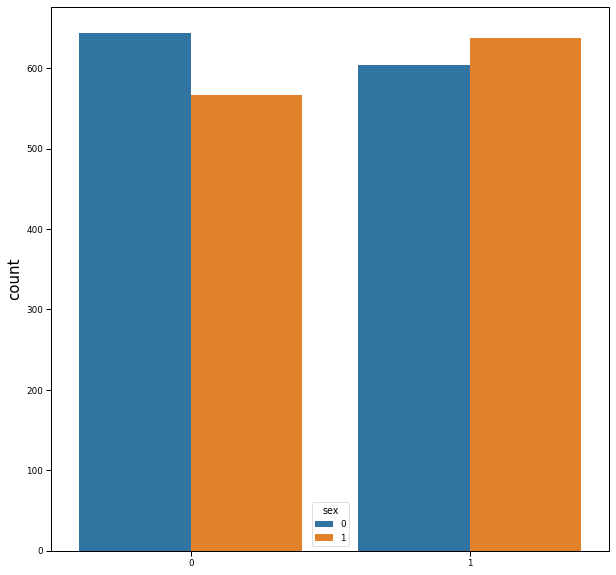

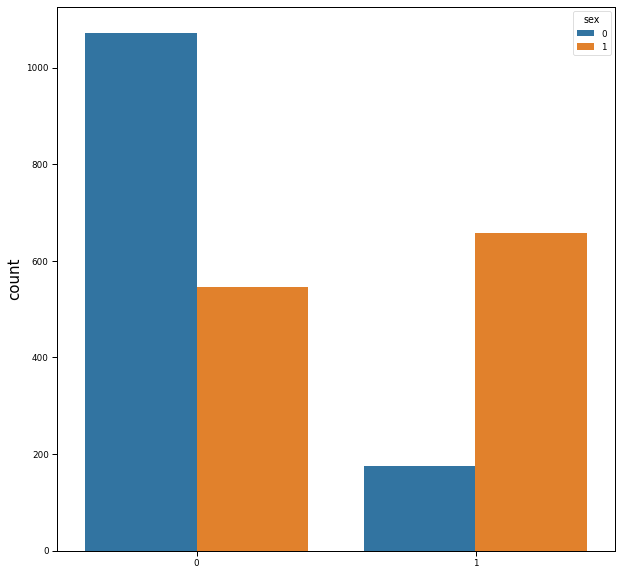

In [63]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model_ward.labels_, hue="sex")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model1_ward.labels_, hue="sex")
plt.show()

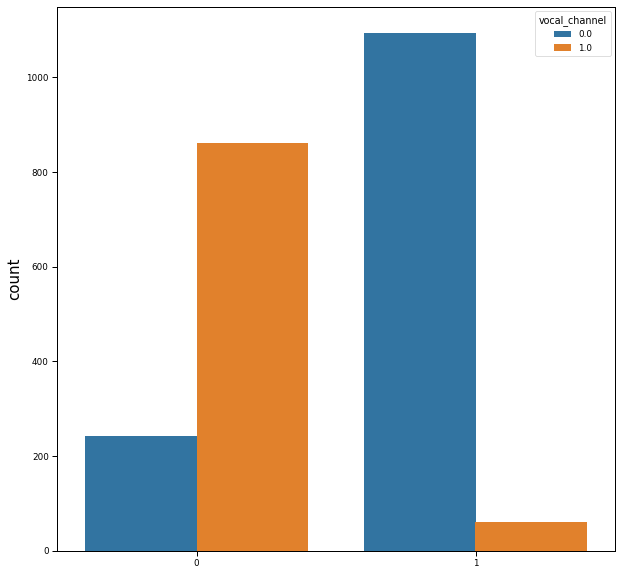

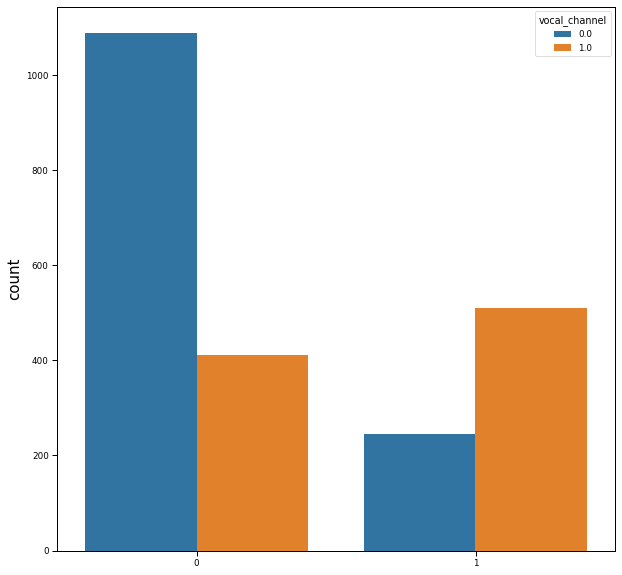

In [64]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model_ward.labels_, hue="vocal_channel")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model1_ward.labels_, hue="vocal_channel")
plt.show()

### Ward PCA analysis

2D

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

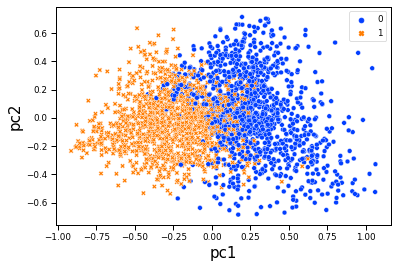

In [65]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=model_ward.labels_, style=model_ward.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

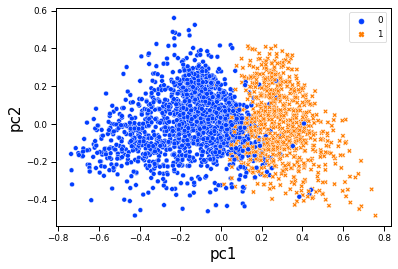

In [66]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=model1_ward.labels_, style=model1_ward.labels_, palette="bright")

3D

In [67]:
principal3dDf = principal3dDf.drop(columns=["dbscan_labels"])
principal3dDf1 = principal3dDf1.drop(columns=["dbscan_labels"])
principal3dDf["wlabel"]=model1_ward.labels_
principal3dDf1["wlabel"]=model1_ward.labels_

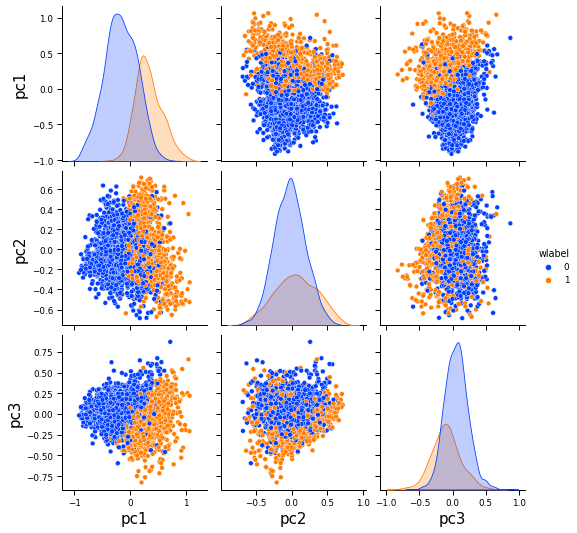

In [68]:
sns.pairplot(data=principal3dDf, hue="wlabel", palette="bright")
plt.show()

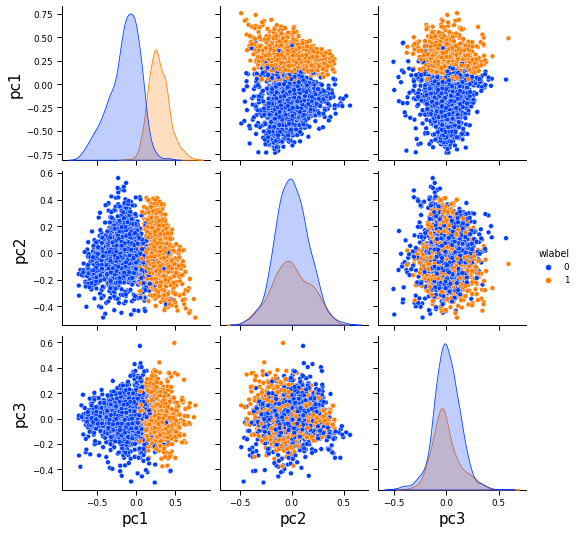

In [69]:
sns.pairplot(data=principal3dDf1, hue="wlabel", palette="bright")
plt.show()

### Average linkage

In [70]:
model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model_avg = model_avg.fit(X_minmax)

model1_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model1_avg = model1_avg.fit(X_minmax1)
'''
model2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model2_avg = model2_avg.fit(X_minmax2)

model3_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model3_avg = model3_avg.fit(X_minmax3)'''

"\nmodel2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')\nmodel2_avg = model2_avg.fit(X_minmax2)\n\nmodel3_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')\nmodel3_avg = model3_avg.fit(X_minmax3)"

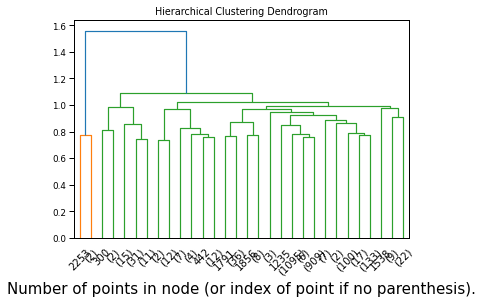

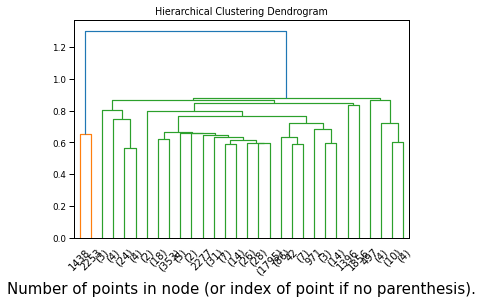

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_avg, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_avg, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [71]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''

### Maximum linkage

In [72]:
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(X_minmax)

model1_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model1_complete = model1_complete.fit(X_minmax1)
'''
model2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model2_complete = model2_complete.fit(X_minmax2)

model3_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model3_complete = model3_complete.fit(X_minmax3)'''

"\nmodel2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')\nmodel2_complete = model2_complete.fit(X_minmax2)\n\nmodel3_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')\nmodel3_complete = model3_complete.fit(X_minmax3)"

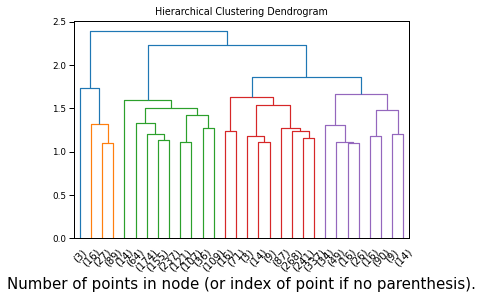

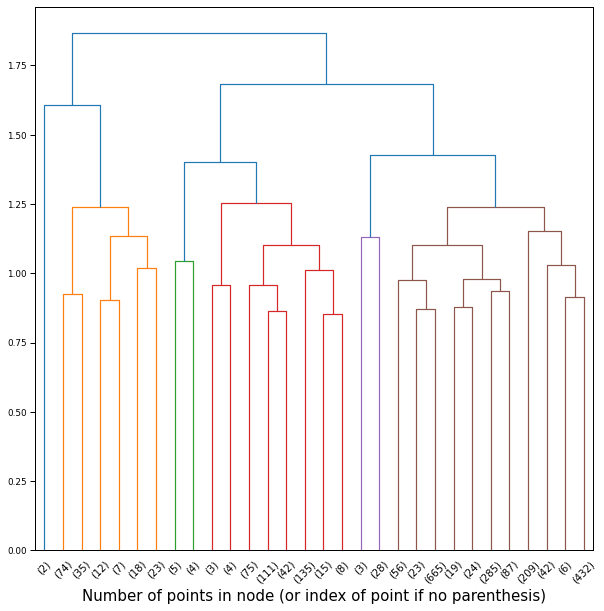

In [73]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.figure(figsize=(10,10))
plot_dendrogram(model1_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis)", fontsize=15)
plt.show()

In [74]:
model_complete = AgglomerativeClustering(distance_threshold=None, n_clusters=4, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(X_minmax)
hist, bins = np.histogram(model_complete.labels_, bins=range(0, len(set(model_complete.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, model_complete.labels_))

model1_complete = AgglomerativeClustering(distance_threshold=None, n_clusters=5, affinity='euclidean', linkage='complete')
model1_complete = model1_complete.fit(X_minmax1)
hist, bins = np.histogram(model1_complete.labels_, bins=range(0, len(set(model1_complete.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax1, model1_complete.labels_))

labels {0: 135, 1: 254, 2: 1017, 3: 1046}
silhouette 0.13470231717623316
labels {0: 402, 1: 169, 2: 1848, 3: 2, 4: 31}
silhouette 0.17338912706906495


In [113]:
np.unique(model1_complete.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 402,  169, 1848,    2,   31]))

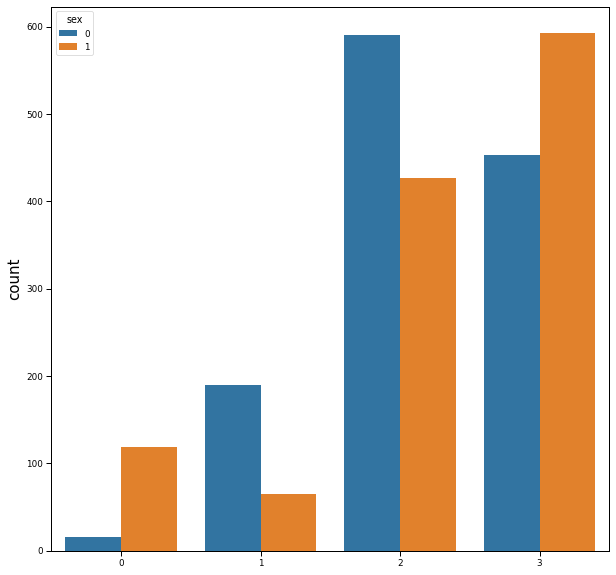

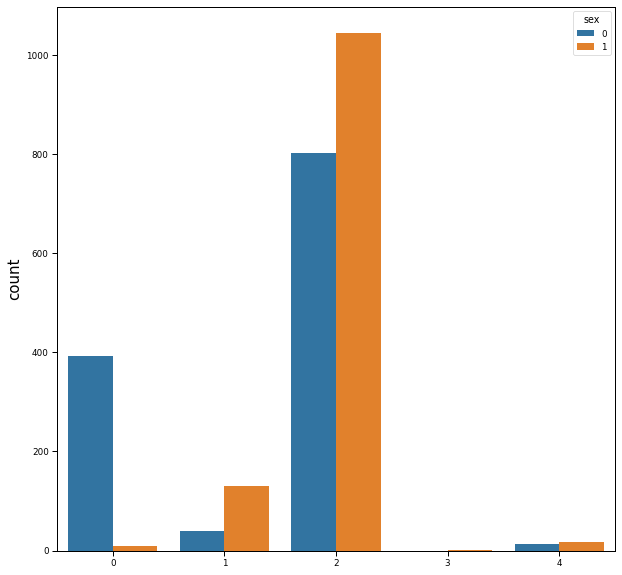

In [75]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model_complete.labels_, hue="sex")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model1_complete.labels_, hue="sex")
plt.show()

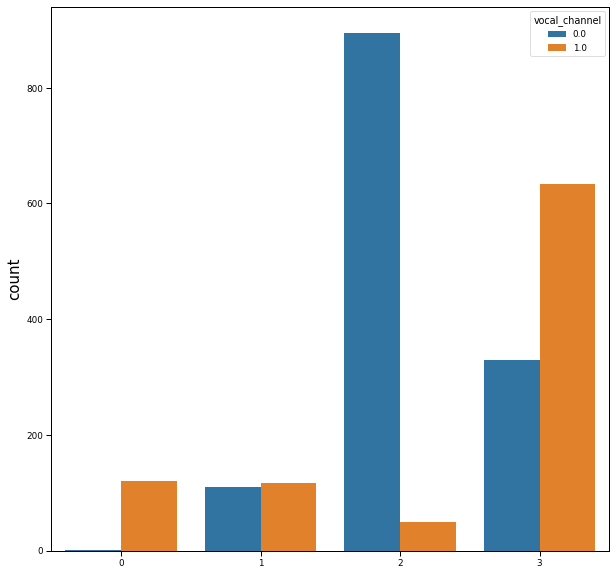

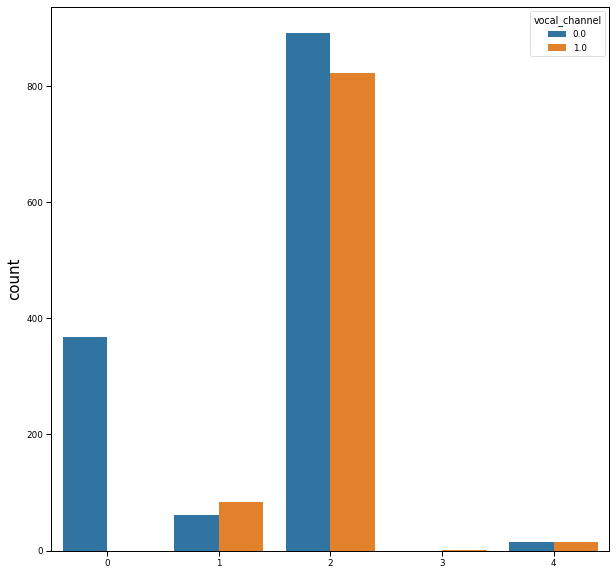

In [76]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model_complete.labels_, hue="vocal_channel")
plt.show()

plt.figure(figsize=(10,10))
sns.countplot(data=dfcopy1, x=model1_complete.labels_, hue="vocal_channel")
plt.show()

### Maximum PCA analysis

2D

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

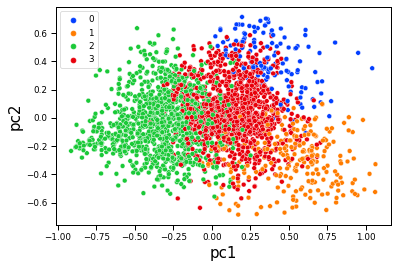

In [77]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=model_complete.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

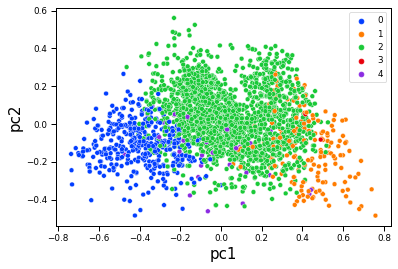

In [78]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=model1_complete.labels_, palette="bright")

3D

In [79]:
principal3dDf = principal3dDf.drop(columns=["wlabel"])
principal3dDf1 = principal3dDf1.drop(columns=["wlabel"])
principal3dDf["clabel"]=model_complete.labels_
principal3dDf1["clabel"]=model1_complete.labels_

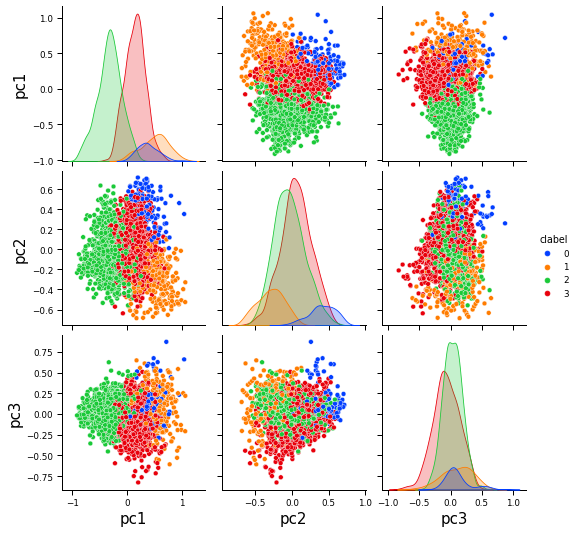

In [80]:
sns.pairplot(data=principal3dDf, hue="clabel", palette="bright")
plt.show()

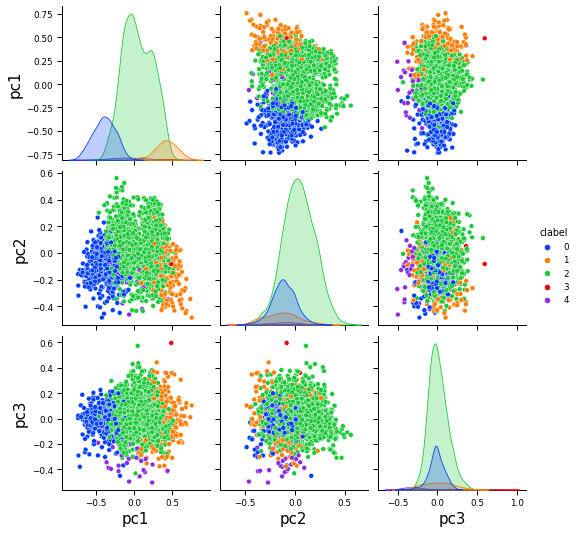

In [81]:
sns.pairplot(data=principal3dDf1, hue="clabel", palette="bright")
plt.show()

### Minimum

In [82]:
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model_single = model_single.fit(X_minmax)

model1_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model1_single = model1_single.fit(X_minmax1)
'''
model2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model2_single = model2_single.fit(X_minmax2)

model3_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model3_single = model3_single.fit(X_minmax3)'''

"\nmodel2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')\nmodel2_single = model2_single.fit(X_minmax2)\n\nmodel3_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')\nmodel3_single = model3_single.fit(X_minmax3)"

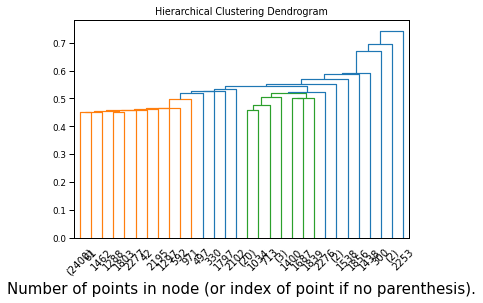

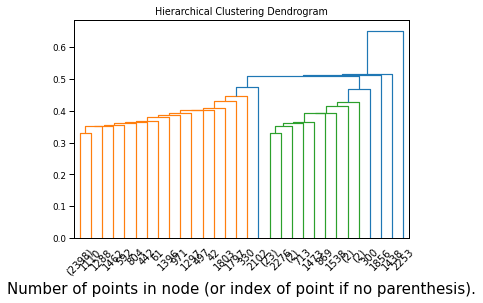

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_single, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_single, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [83]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''